<a href="https://colab.research.google.com/github/jacquesbilombe/CRM-Customer-Churn-Score/blob/main/CustomerChurn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The dataset for this project can be found on the project's GitHub repository or at [Kaggle](https://www.kaggle.com/datasets/mathchi/churn-for-bank-customers/data). This project serves as a case study for the Data Science and Analytics course at PUC RIO. For more information, please refer to the project README.

In [1]:
import os
import csv
import random
import warnings
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from collections import Counter
from sklearn import preprocessing
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,recall_score, classification_report
from sklearn.feature_selection import SelectKBest, chi2,mutual_info_classif, f_classif
from sklearn.metrics import confusion_matrix, f1_score, precision_score, roc_auc_score, roc_curve, auc, make_scorer
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import train_test_split, cross_val_predict, KFold, cross_val_score, GridSearchCV, StratifiedKFold, RepeatedStratifiedKFold

## Other configurations

In [2]:
%matplotlib inline
warnings.filterwarnings('ignore')

# Get the data access
! git clone https://github.com/jacquesbilombe/CRM-Customer-Churn-Score.git

# Set the csv format
pd.options.display.float_format = '{:.2f}'.format

Cloning into 'CRM-Customer-Churn-Score'...
remote: Enumerating objects: 93, done.
remote: Counting objects: 100% (93/93), done.
remote: Compressing objects: 100% (86/86), done.
remote: Total 93 (delta 29), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (93/93), 1.01 MiB | 7.36 MiB/s, done.
Resolving deltas: 100% (29/29), done.


## Data Exploration

In [3]:
# Files path
data_folder = os.path.join('CRM-Customer-Churn-Score', 'dataset')
df = pd.read_csv(data_folder + '/' + 'churn.csv').drop(['RowNumber'],axis=1)
df1 = df.copy(deep = True)
df.head(5)

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
def summary_data(df, head=5):
    func = {
        "Info": df.info(),
        "Shape": df.shape,
        "Ndim": df.ndim,
        "Null": df.isnull().sum(),
        "Describe": df.describe().T
    }

    for n, f in func.items():
        print("\n################### ", n, " ###################\n")
        if isinstance(f, pd.DataFrame) or isinstance(f, pd.Series):
            print(f)
        else:
            print(f)

summary_data(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   Surname          10000 non-null  object 
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           10000 non-null  int64  
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  int64  
 10  IsActiveMember   10000 non-null  int64  
 11  EstimatedSalary  10000 non-null  float64
 12  Exited           10000 non-null  int64  
dtypes: float64(2), int64(8), object(3)
memory usage: 1015.8+ KB

###################  Info  ###################

None

###################  Shape  ###################

(10000, 13)

################### 

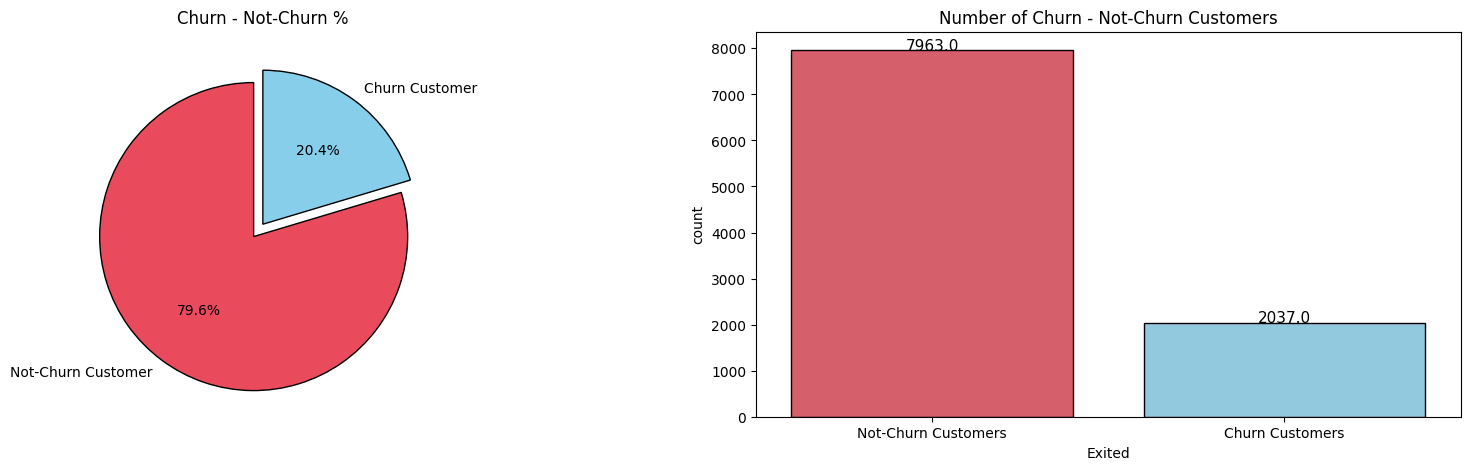

In [5]:
#Visualizing the distribution of customer churn to assess dataset imbalance
colors = ['#E94B5C','#87CEEB']

l = list(df1['Exited'].value_counts())
circle = [l[0] / sum(l) * 100,l[1] / sum(l) * 100]

# Pie plot
fig = plt.subplots(nrows = 1,ncols = 2,figsize = (20,5))
plt.subplot(1,2,1)
plt.pie(circle,labels = ['Not-Churn Customer','Churn Customer'],autopct = '%1.1f%%',startangle = 90,explode = (0.1,0),colors = colors,
       wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('Churn - Not-Churn %');

plt.subplot(1,2,2)
ax = sns.countplot(x='Exited', data=df1, palette=colors, edgecolor='black')

for rect in ax.patches:
    ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 2, rect.get_height(), horizontalalignment='center', fontsize = 11)
ax.set_xticklabels(['Not-Churn Customers','Churn Customers'])

plt.title('Number of Churn - Not-Churn Customers');
plt.show()

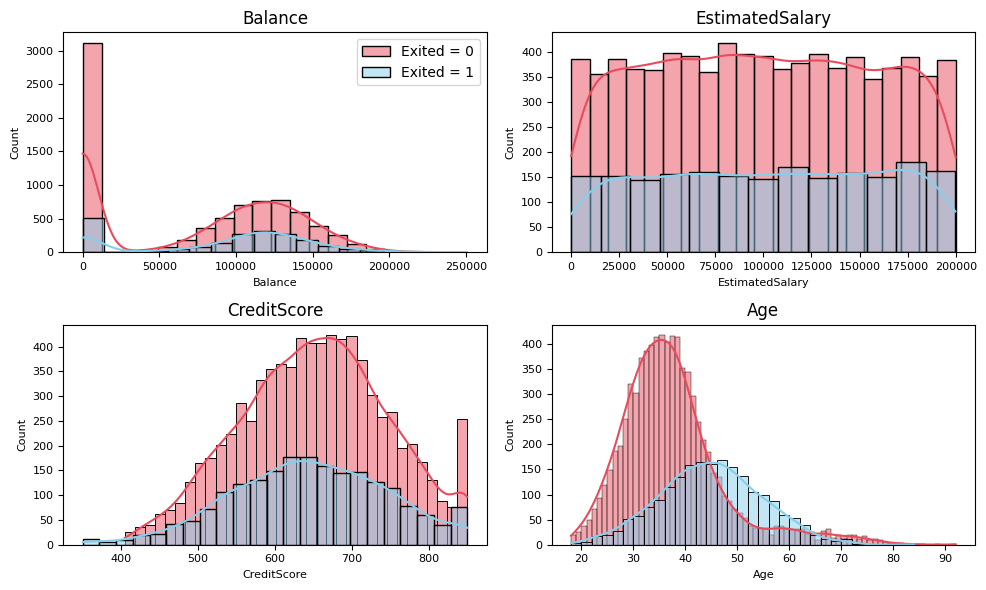

In [6]:
# Exploring the distribution differences between
# exited and not exited customers for numerical features
numerical_features = df[['Balance', 'EstimatedSalary',
                         'CreditScore', 'Age', 'Exited']].copy()
exit_values = numerical_features['Exited'].unique()

sns.set_palette(sns.color_palette(colors))

plt.figure(figsize=(10, 6))

for i, feature in enumerate(numerical_features.columns[:-1]):
    plt.subplot(2, 2, i + 1)

    sns.histplot(data=numerical_features[numerical_features['Exited'] == 0],
                 x=feature, kde=True, label='Exited = 0', color=colors[0])
    sns.histplot(data=numerical_features[numerical_features['Exited'] == 1],
                 x=feature, kde=True, label='Exited = 1', color=colors[1])

    plt.title(f'{feature}', fontsize=12)
    plt.xlabel(feature, fontsize=8)
    plt.ylabel('Count', fontsize=8)
    plt.tick_params(axis='both', labelsize=8)

    if i > 0:
        plt.legend().set_visible(False)
    else:
        plt.legend()

plt.tight_layout()
plt.show()

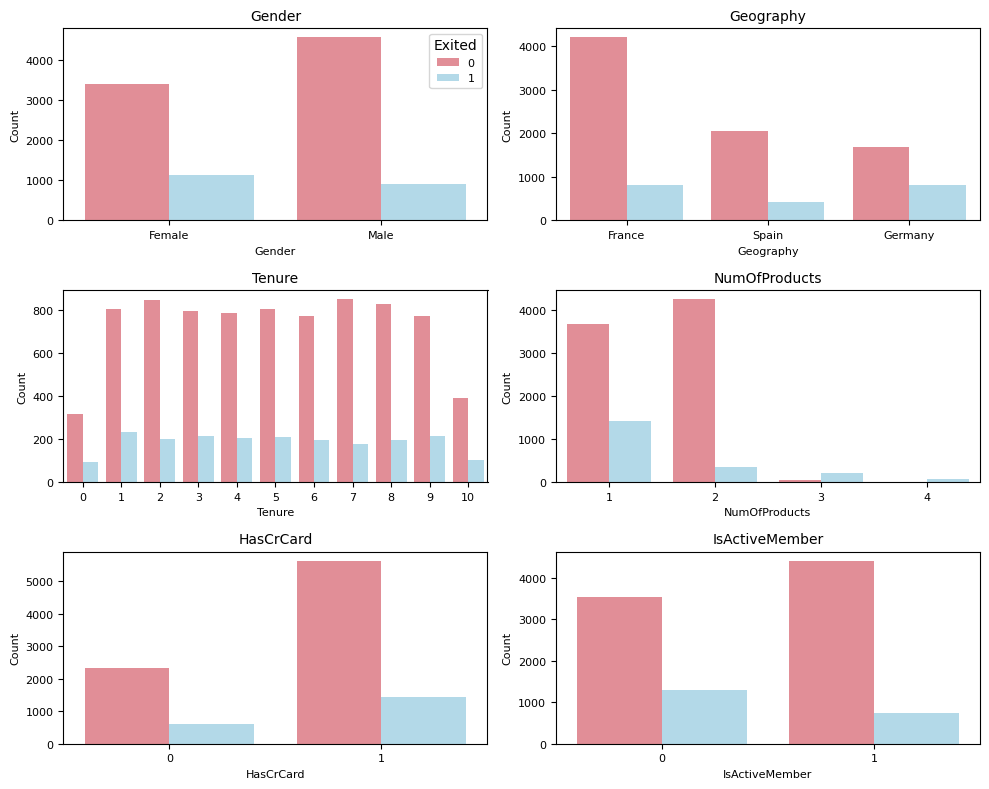

In [7]:
# Exploring the distribution differences between
# exited and not exited customers for categorical features

categorical_features = df[['Gender', 'Geography',
            'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Exited']]

sns.set_palette("deep")

plt.figure(figsize=(10, 8))

for i, feature in enumerate(categorical_features.columns[:-1]):
    plt.subplot(3, 2, i + 1)

    sns.countplot(data=categorical_features, x=feature, hue='Exited', alpha=0.7, palette=[colors[0], colors[1]])

    plt.title(f'{feature}', fontsize=10)
    plt.xlabel(feature, fontsize=8)
    plt.ylabel('Count', fontsize=8)
    plt.tick_params(axis='both', labelsize=8)
    if i > 0:
        plt.legend().set_visible(False)
    else:
        plt.legend(title='Exited', fontsize=8)
plt.tight_layout()
plt.show()

### Conclusion:
- The dataset exhibits class imbalance, with fewer records for customers who have churned (Exited=1) compared to those who haven't (Exited=0).
- Possessing a credit card (HasCrCard) does not appear to significantly influence the likelihood of churn.
It's important to consider all other columns as they may impact the model's results.

## Pre processing

### Data Scalling

- Machine learning model does not understand the units of the values of the features. It treats the input just as a simple number but does not understand the true meaning of that value. Thus, it becomes necessary to scale the data.

  Eg : Age = Years; Balance = Amounts

- We have 2 options for data scaling : 1) Normalization 2) Standardization. As most of the algorithms assume the data to be normally (Gaussian) distributed, Normalization is done for features whose data does not display normal distribution and standardization is carried out for features that are normally distributed where their values are huge or very small as compared to other features.
- Normalization : Age, Balance, CreditScore and EstimatedSalary features are normalized as they displayed a right skewed and bimodal data distribution.
- Standardization : None of the features are standardized for the above data.

In [8]:
# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Selecting numerical columns for scaling
numerical_columns = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']

df1 = df1.drop(['CustomerId','Surname'],axis=1)
# Fit and transform the selected numerical columns
df1[numerical_columns] = scaler.fit_transform(df[numerical_columns])
df1.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0.54,France,Female,0.32,2,0.00,1,1,1,0.51,1
1,0.52,Spain,Female,0.31,1,0.33,1,0,1,0.56,0
2,0.30,France,Female,0.32,8,0.64,3,1,0,0.57,1
3,0.70,France,Female,0.28,1,0.00,2,0,0,0.47,0
4,1.00,Spain,Female,0.34,2,0.50,1,1,1,0.40,0


### One Hot Encoding

In [9]:
# Variables to apply one hot encoding
lista = ["Gender", "Geography"]
df1 = pd.get_dummies(df1, columns =lista, drop_first = True)
df1.tail()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Gender_Male,Geography_Germany,Geography_Spain
9995,0.84,0.28,5,0.00,2,1,0,0.48,0,True,False,False
9996,0.33,0.23,10,0.23,1,1,1,0.51,0,True,False,False
9997,0.72,0.24,7,0.00,1,0,1,0.21,1,False,False,False
9998,0.84,0.32,3,0.30,2,1,0,0.46,1,True,True,False
9999,0.88,0.14,4,0.52,1,1,0,0.19,0,False,False,False


#### Correlation Matrix

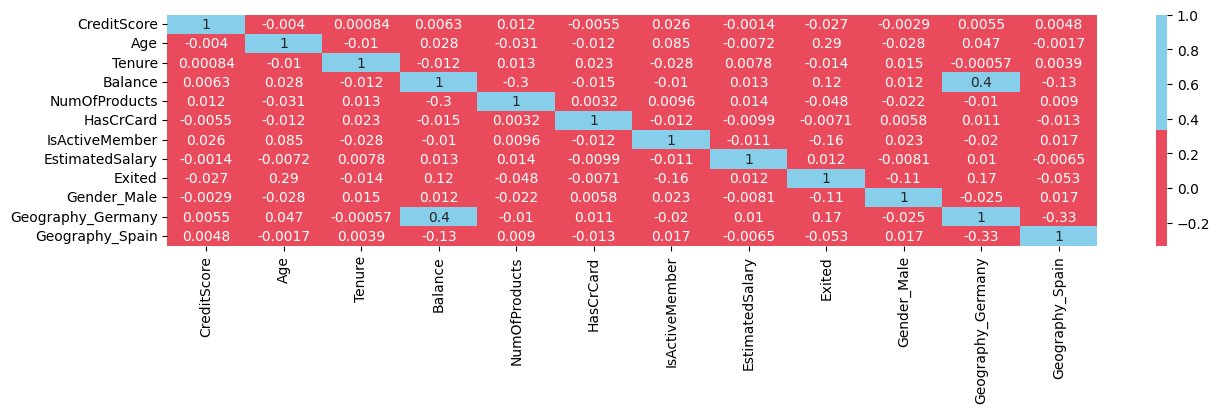

In [10]:
plt.figure(figsize = (15,3))
sns.heatmap(df1.corr(),cmap = colors,annot = True);

- It is a huge matrix with too many features. We will check the correlation only with respect to Churn.

### Features Selection

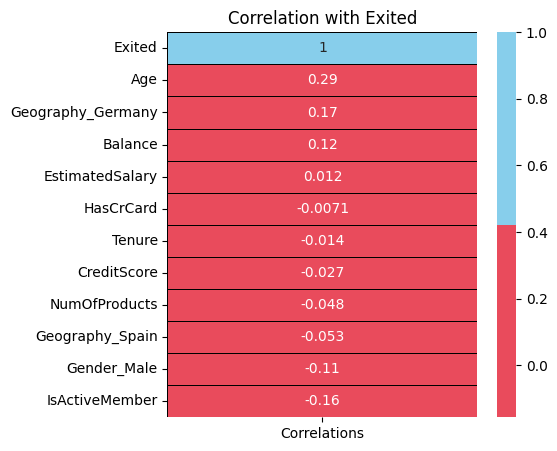

In [11]:
# See the correlation using "Exited" column as the reference
corr = df1.corrwith(df1['Exited']).sort_values(ascending = False).to_frame()
corr.columns = ['Correlations']
plt.subplots(figsize = (5,5))
sns.heatmap(corr,annot = True,cmap = colors,linewidths = 0.4,linecolor = 'black');
plt.title('Correlation with Exited');

- `EstimatedSalary, HasCrCard, Tenue, CreditScore,NumOfProdudcts, Geography_Spain` does not display any kind of correlation. We might drop these features and continue with only those with positive and correlation.

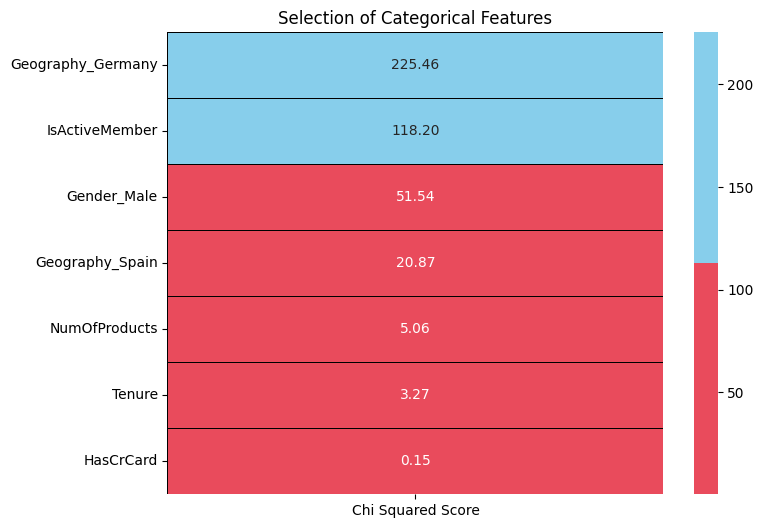

In [12]:
features = df1.loc[:,['Tenure', 'Gender_Male', 'Geography_Germany',
                      'Geography_Spain', 'HasCrCard', 'NumOfProducts',
                      'IsActiveMember']]
target = df1.loc[:,'Exited']

# Initialize SelectKBest with chi2 score function and specify k
best_features = SelectKBest(score_func=chi2, k='all')

# Fit SelectKBest to the data
fit = best_features.fit(features, target)

# Create a DataFrame of feature scores
featureScores = pd.DataFrame({'Chi Squared Score': fit.scores_}, index=features.columns)

# Plot feature scores using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(featureScores.sort_values(by='Chi Squared Score', ascending=False),
            annot=True,
            cmap=colors,
            linewidths=0.5,
            linecolor='black',
            fmt='.2f')
plt.title('Selection of Categorical Features')
plt.show()

- Based on the above result, we can drop `HasCrCard, Tenue and NumOfProducts`by choosing a threshold of 10.

#### Feature Selection for Numerical Features

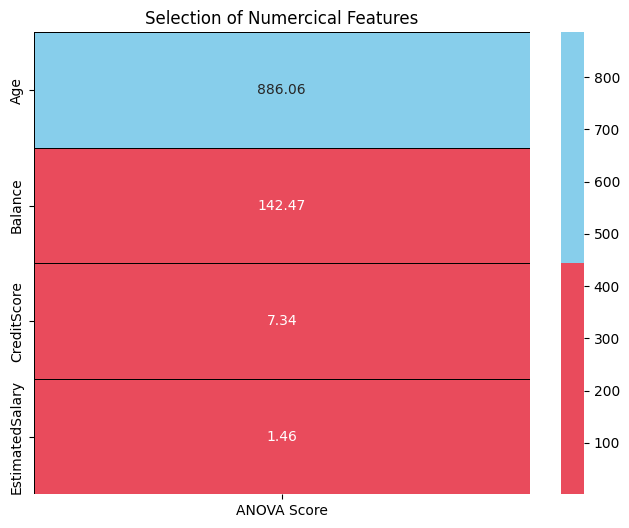

In [13]:
features = df1.loc[:,['CreditScore', 'Age', 'Balance', 'EstimatedSalary']]
target = df1.loc[:,'Exited']

# Initialize SelectKBest with chi2 score function and specify k
best_features = SelectKBest(score_func=f_classif, k='all')

# Fit SelectKBest to the data
fit = best_features.fit(features, target)

# Create a DataFrame of feature scores
featureScores = pd.DataFrame({'ANOVA Score': fit.scores_}, index=features.columns)

# Plot feature scores using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(featureScores.sort_values(by='ANOVA Score', ascending=False),
            annot=True,
            cmap=colors,
            linewidths=0.5,
            linecolor='black',
            fmt='.2f')
plt.title('Selection of Numercical Features')
plt.show()

- For the Anova method, higher is the score high is value of the feature. We're going to consider threshold score as 10.

In [14]:
df1.drop(columns = ['HasCrCard', 'Tenure',  'NumOfProducts', 'EstimatedSalary'],inplace = True)
df1.head()

,CreditScore,Age,Balance,IsActiveMember,Exited,Gender_Male,Geography_Germany,Geography_Spain
0,0.54,0.32,0.00,1,1,False,False,False
1,0.52,0.31,0.33,1,0,False,False,True
2,0.30,0.32,0.64,0,1,False,False,False
3,0.70,0.28,0.00,0,0,False,False,False
4,1.00,0.34,0.50,1,0,False,False,True


#### Data Balancing using SMOTE

- As seem during the data exploration, our dataset isn't balaced.
- With 76.6% of data as `No Churned Costumer` and 20.4% as `Churned`.
- We'll try to balance the dataset for a good result during Modeling.

In [15]:
# Move the "Exited" column at the last position
cols = df1.columns.tolist()
cols.remove('Exited')
cols.append('Exited')
df1 = df1[cols]
df1.head(5)


,CreditScore,Age,Balance,IsActiveMember,Gender_Male,Geography_Germany,Geography_Spain,Exited
0,0.54,0.32,0.00,1,False,False,False,1
1,0.52,0.31,0.33,1,False,False,True,0
2,0.30,0.32,0.64,0,False,False,False,1
3,0.70,0.28,0.00,0,False,False,False,0
4,1.00,0.34,0.50,1,False,False,True,0


In [16]:
over = SMOTE(sampling_strategy = 1)

X = df1.drop("Exited",axis=1)
y = df1["Exited"]

X, y = over.fit_resample(X, y)


## Modeling

In [17]:
# Selecting the features from the above conducted tests and splitting the data into 80 - 20 train - test groups.
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, shuffle=True, random_state = 42, stratify=y)

# Parâmetros e partições da validação cruzada
scoring = 'accuracy'
num_particoes = 10
# validação cruzada com estratificação
kfold = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=7)

In [21]:
# models list
models = [('LogisticRegression', LogisticRegression(max_iter=200)),
          ('KNN', KNeighborsClassifier()),
          ('DecisionTree', DecisionTreeClassifier()),
          ('RandomForest', RandomForestClassifier()),
          ('SVR', SVC(gamma='auto')),
          ('GadientBoosting', GradientBoostingClassifier()),
          ('XGBoost', XGBClassifier())]
#('LightGBM', LGBMClassifier()),

# Define the base estimator for BaggingClassifier
base = DecisionTreeClassifier()
# Number of trees for ensemble models
num_trees = 100
max_features = 3

# Criando os modelos para o VotingClassifier
bases = []
model1 = LogisticRegression(max_iter=200)
bases.append(('logistic', model1))

model2 = KNeighborsClassifier()
bases.append(('KNN', model2))

model3 = SVC(gamma='auto')
bases.append(('svm', model3))

model4 = LGBMClassifier()
bases.append(('LightGBM', model4))

# Define the ensemble models
bg = BaggingClassifier(base_estimator=base, n_estimators=num_trees)
rf = RandomForestClassifier(n_estimators=num_trees, max_features=max_features)
et = ExtraTreesClassifier(n_estimators=num_trees, max_features=max_features)
gb = GradientBoostingClassifier(n_estimators=num_trees)
voting_ensemble = VotingClassifier(bases)

# Add ensemble models to the list of models
models.extend([('Bagging', bg),
               ('RandomForest', rf),
               ('ExtraTrees', et),
               ('GadientBoosting', gb)])

### Model Validation

- We're going to analyse the models performancies using: Confusion Matrix and Cross Validation method

In [22]:
def val_model(name, classifier, x_train, y_train, x_test, y_test):
    # Fit the classifier
    classifier.fit(x_train, y_train)
    prediction = classifier.predict(x_test)
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

    # Calculate metrics
    cv_score_mean = cross_val_score(classifier, x_train, y_train, cv=cv, scoring=scoring).mean()
    cv_score_std = cross_val_score(classifier, x_train, y_train, cv=cv, scoring=scoring).std()
    roc_auc = roc_auc_score(y_test, prediction)
    f1 = f1_score(y_test, prediction)

    # Create a DataFrame to store the metrics
    metrics_df = pd.DataFrame({
        'Model': [name],
        'Cross Validation Score (Mean)': [cv_score_mean],
        'Cross Validation Std': [cv_score_std],
        'ROC_AUC Score': [roc_auc],
        'F1 Score': [f1]
    })

    return metrics_df


# Models Validation
results_df = pd.DataFrame(columns=['Model', 'Cross Validation Score (Mean)', 'Cross Validation Std', 'ROC_AUC Score', 'F1 Score'])
for name, model in models:
    metrics_df = val_model(name, model, x_train, y_train, x_test, y_test)
    results_df = pd.concat([results_df, metrics_df], ignore_index=True)

results_df

,Model,Cross Validation Score (Mean),Cross Validation Std,ROC_AUC Score,F1 Score
0,LR,0.71,0.01,0.70,0.70
1,KNN,0.79,0.01,0.79,0.80
2,CART,0.81,0.01,0.80,0.80
3,RF,0.84,0.01,0.84,0.84
4,SVR,0.71,0.01,0.71,0.69
5,GB,0.80,0.01,0.78,0.78
6,XGBoost,0.84,0.01,0.84,0.83
7,BG,0.86,0.01,0.85,0.85
8,RF,0.85,0.01,0.84,0.84
9,ET,0.84,0.01,0.84,0.84


### Model or Hyperparameter Turning

We'll apply a model tuning to optimize the model's performance further. This involves searching for the best combination of model hyperparameters using techniques such as grid search or random search. This notebook will use Grid.

In [26]:
# Define parameter grids for each model
param_grid = {
    'LogisticRegression': {'C': [0.001, 0.01, 0.1, 1, 10]},
    'KNN': {'n_neighbors': [3, 5, 7, 9]},
    'DecisionTree': {'max_depth': [None, 10, 20, 30]},
    'RabdomForest': {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30]},
    'SVR': {'C': [0.001, 0.01, 0.1, 1, 10], 'kernel': ['linear', 'rbf']},
    'GadientBoosting': {'learning_rate': [0.01, 0.1, 1], 'n_estimators': [100, 200, 300], 'max_depth': [3, 5, 7]},
    'XGBoost': {'learning_rate': [0.01, 0.1, 1], 'n_estimators': [100, 200, 300]}
    }
# 'LightGBM': {'learning_rate': [0.01, 0.1, 1], 'n_estimators': [100, 200, 300]},
# Define scoring function
scoring = make_scorer(roc_auc_score)

# Perform Grid Search for each model and save the best model parameters
best_models = {}
for name, model in models:
    param_grid_model = param_grid.get(name, {})
    grid_search = GridSearchCV(model, param_grid_model, cv=5, scoring=scoring)
    grid_search.fit(x_train, y_train)
    best_models[name] = grid_search.best_estimator_

# evaluate each model in turn
results_df_turn = pd.DataFrame(columns=['Model', 'Cross Validation Score (Mean)', 'Cross Validation Std', 'ROC_AUC Score', 'F1 Score'])
for key, value in best_models.items():
    metrics_df_turn = val_model(key, value, x_train, y_train, x_test, y_test)
    results_df_turn = pd.concat([results_df_turn, metrics_df_turn], ignore_index=True)

results_df_turn

,Model,Cross Validation Score (Mean),Cross Validation Std,ROC_AUC Score,F1 Score
0,LR,0.71,0.01,0.70,0.70
1,KNN,0.80,0.01,0.80,0.81
2,CART,0.81,0.01,0.80,0.80
3,RF,0.85,0.01,0.85,0.85
4,SVR,0.72,0.01,0.71,0.70
5,GB,0.87,0.01,0.87,0.86
6,XGBoost,0.84,0.01,0.84,0.83
7,BG,0.86,0.01,0.84,0.84
8,ET,0.84,0.01,0.84,0.84


In the majority, the models metric scores inscreased after optimazing the hyperparameters.
- Eg: The algorithm ExtraTreesClassifier performed well after the turning process; from 0.8 of Cross-Validation mean to 0.84; and from 0.78 of f1 score to 0.84



Confusion Matrix to analyze where our models performed well in classifying churned customers.

## Conclusion

Based on the above metrics, we can draw the following conclusions:

- Gradient Boosting (GB) achieved the highest Cross Validation Score (Mean) and the highest ROC_AUC Score, indicating the best overall performance among the models.
- The Random Forest (RF) model also performed strongly, with high scores across all metrics.
- The Bagging (BG) and Extra Trees (ET) models also performed well, with scores similar to Gradient Boosting and Random Forest.
The Support Vector Regressor (SVR) model had the lowest performance among the evaluated models, with relatively lower scores across all metrics.

The one might choose Gradient Boosting as the preferred model due to its superior overall performance. However, additional considerations such as model interpretability, training time, and computational resources may also influence the selection of the final model.